In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def read_metrics_csv(dataset, method):
    df = pd.read_csv(f"results/{dataset}/{method}_metrics.csv")
    runs = [group for _, group in df.groupby("run_id")]
    return runs


In [4]:
def read_summaries(dataset, method, stage):
    df = pd.read_csv(f"results/{dataset}/{stage}/{method}_summaries.csv")
    summaries = [group for _, group in df.groupby("run_id")]
    return summaries



In [5]:
def read_summaries(dataset, method, stage):
    df = pd.read_csv(f"results/{dataset}/{stage}/{method}_summaries.csv")
    df["method"] = method  # Add a column to indicate the method
    df["dataset"] = dataset  # Add a column to indicate the dataset
    return df

# List of methods
methods = ["regular", "regular-decorr", "vibcreg", "vibcreg-decorr", "barlowtwins", "barlowtwins-decorr","byol", "byol-decorr" ]

datasets = [
    "ElectricDevices",
    "StarLightCurves",
    "Wafer",
    "ECG5000",
    "TwoPatterns",
    "FordA",
    "UWaveGestureLibraryAll",
    "FordB",
    "ChlorineConcentration",
    "ShapesAll",
]

# Read the summaries for all methods and all datasets into a single DataFrame
all_summaries_stage1 = pd.concat([read_summaries(dataset, method, "stage1") for dataset in datasets for method in methods])
all_summaries_stage2 = pd.concat([read_summaries(dataset, method, "stage2") for dataset in datasets for method in methods])

In [11]:
# all_summaries_stage1[all_summaries_stage1['dataset'] == "Wafer" ] 
# all_summaries_stage1[all_summaries_stage1['dataset'] == "Wafer" ].sort_values(by="val_perplexity")
all_summaries_stage2[all_summaries_stage2['dataset'] == "FordA" ].sort_values(by="IS_mean")
# all_summaries_stage2.shape


,kurtosis,coverage,entropy,FID,IS_mean,prior_loss,IS_std,skewness,variety (Gini),run_id,method,dataset
1,6.311411,0.747500,3.077173,4.129770,1.165171,0.022499,0.033161,2.529478,0.456617,adirag0l,vibcreg-decorr,FordA
0,14.206888,0.738750,3.040106,3.514573,1.199984,1.547312,0.043555,3.572428,0.469858,708b8h8d,regular-decorr,FordA
1,-0.574487,0.677188,3.073530,3.169585,1.200321,1.149583,0.032801,0.899572,0.487150,yaebptn5,byol,FordA
1,3.290894,0.758125,3.137573,3.427851,1.230245,0.371204,0.045088,1.960179,0.436383,exz7mfpb,vibcreg,FordA
0,3.168125,0.778750,3.186245,2.652884,1.258377,1.363427,0.040483,1.865666,0.403467,6eh2vdrm,regular,FordA
1,6.642660,0.765625,3.111717,2.960117,1.269227,1.085637,0.033395,2.700171,0.425200,x45i29il,barlowtwins-decorr,FordA
0,-0.042306,0.712188,3.120052,3.300520,1.296277,1.751987,0.041184,0.957306,0.458575,kibo8x8r,byol-decorr,FordA
0,3.548208,0.798437,3.216203,2.870946,1.308364,1.274291,0.047639,1.875222,0.384917,ziv3a52s,vibcreg,FordA
0,4.734532,0.765312,3.138917,3.289098,1.324405,0.660181,0.036897,2.144510,0.430425,5cjo94nv,vibcreg-decorr,FordA
0,-1.104480,0.698125,3.140958,1.754273,1.331753,0.183343,0.034058,0.569109,0.443600,aap6nlvq,byol,FordA


/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_74770/378100335.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_74770/378100335.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_74770/378100335.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation

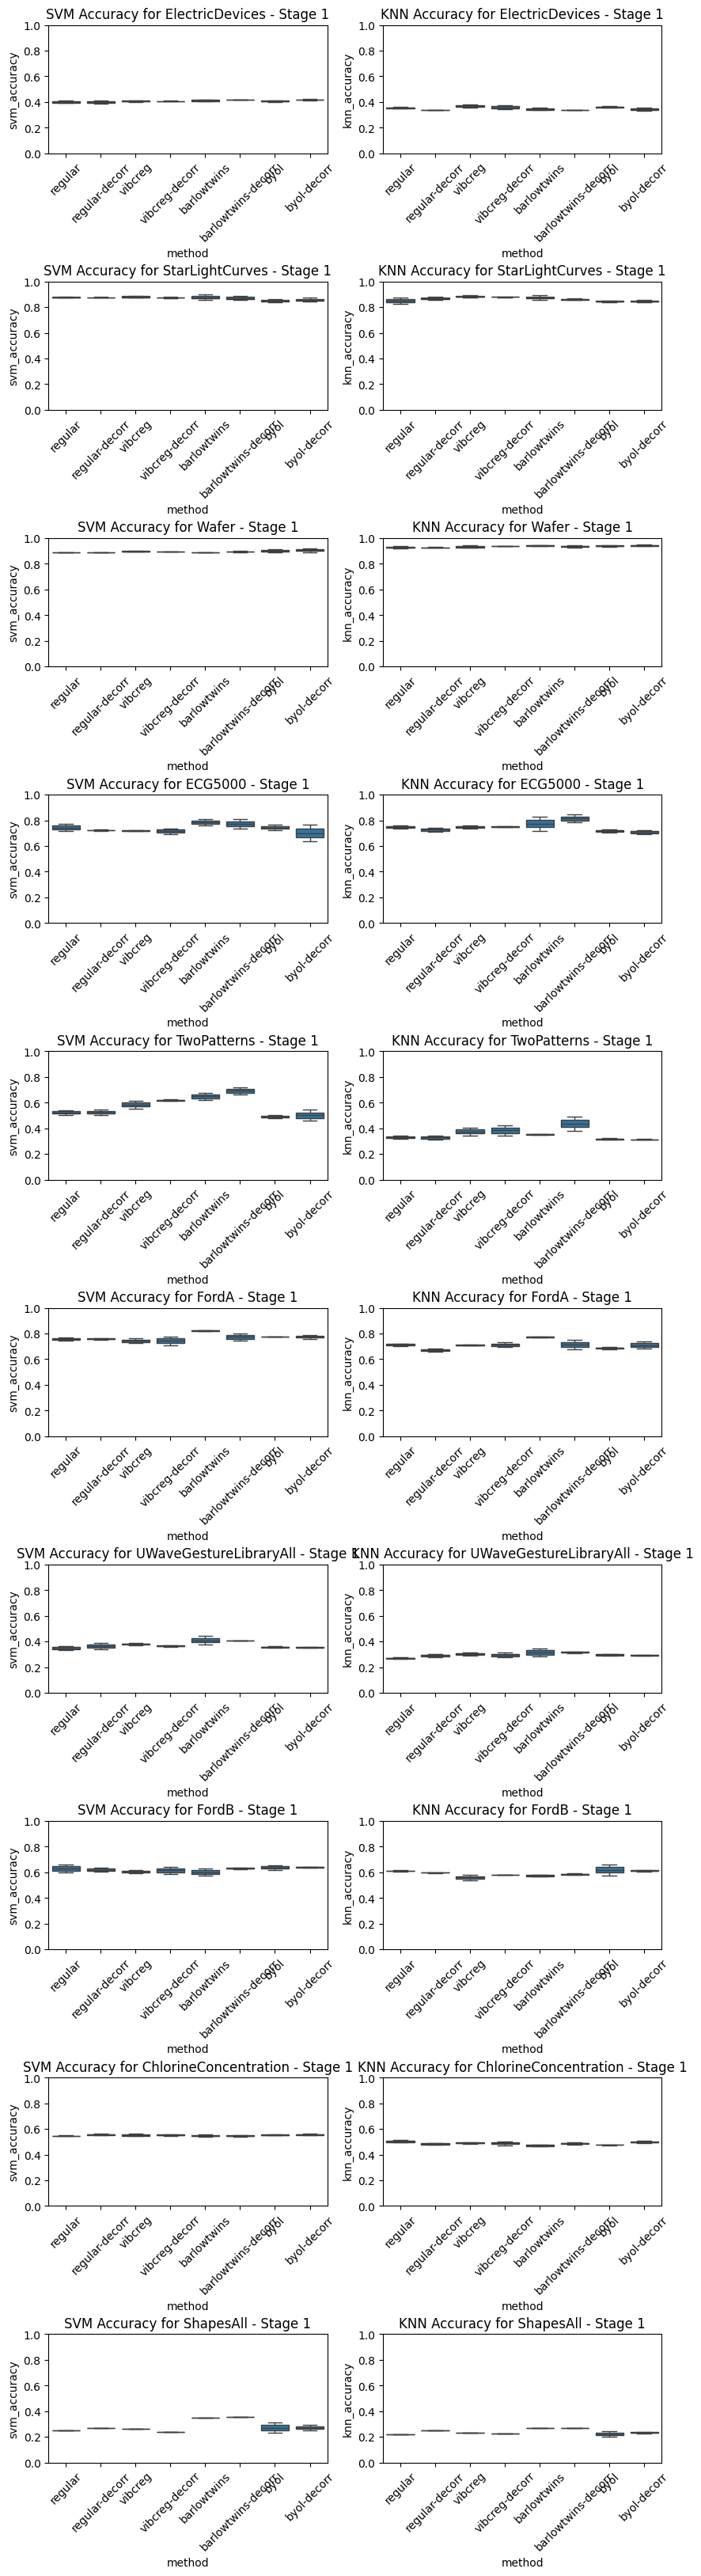

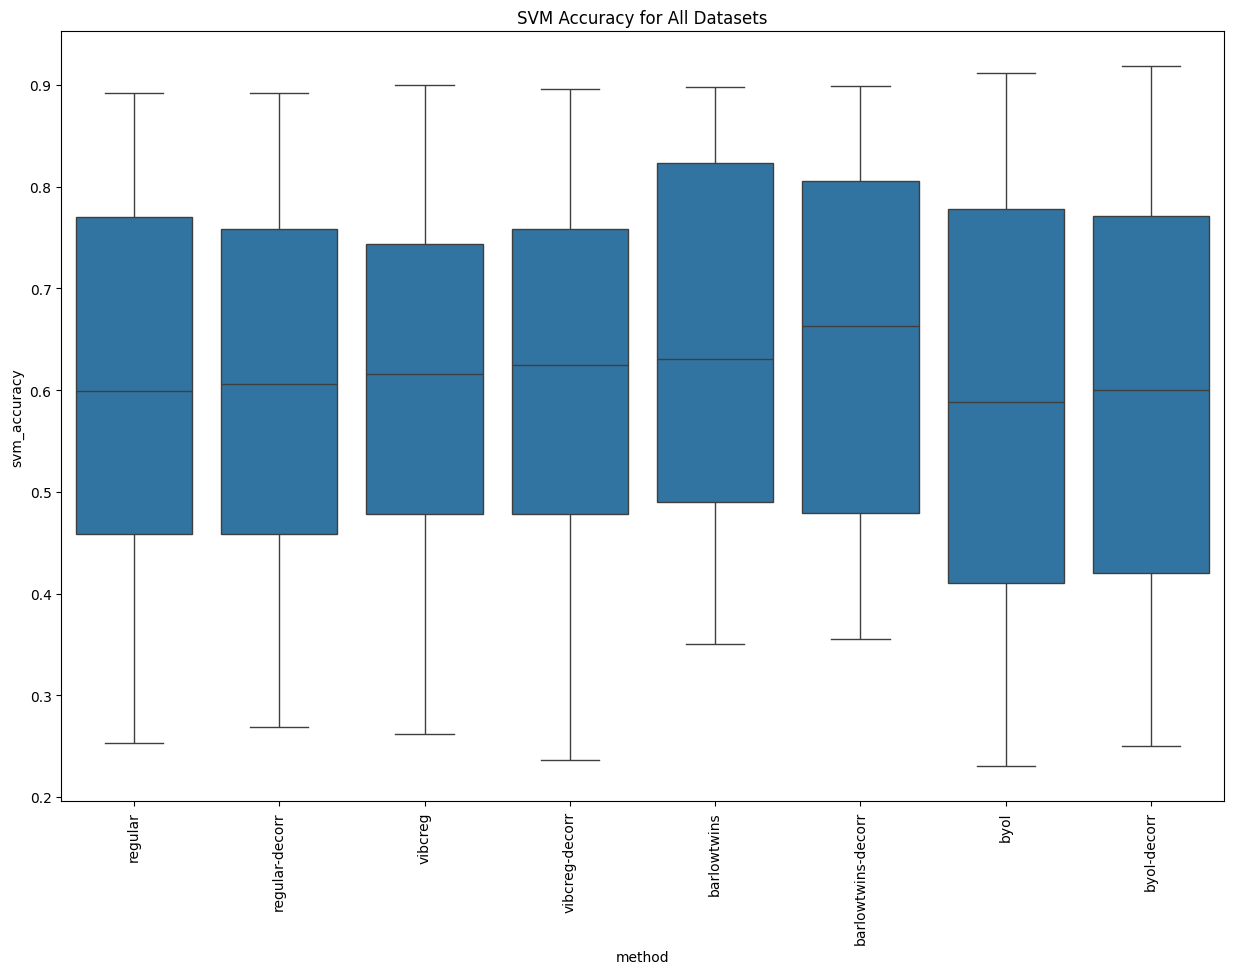

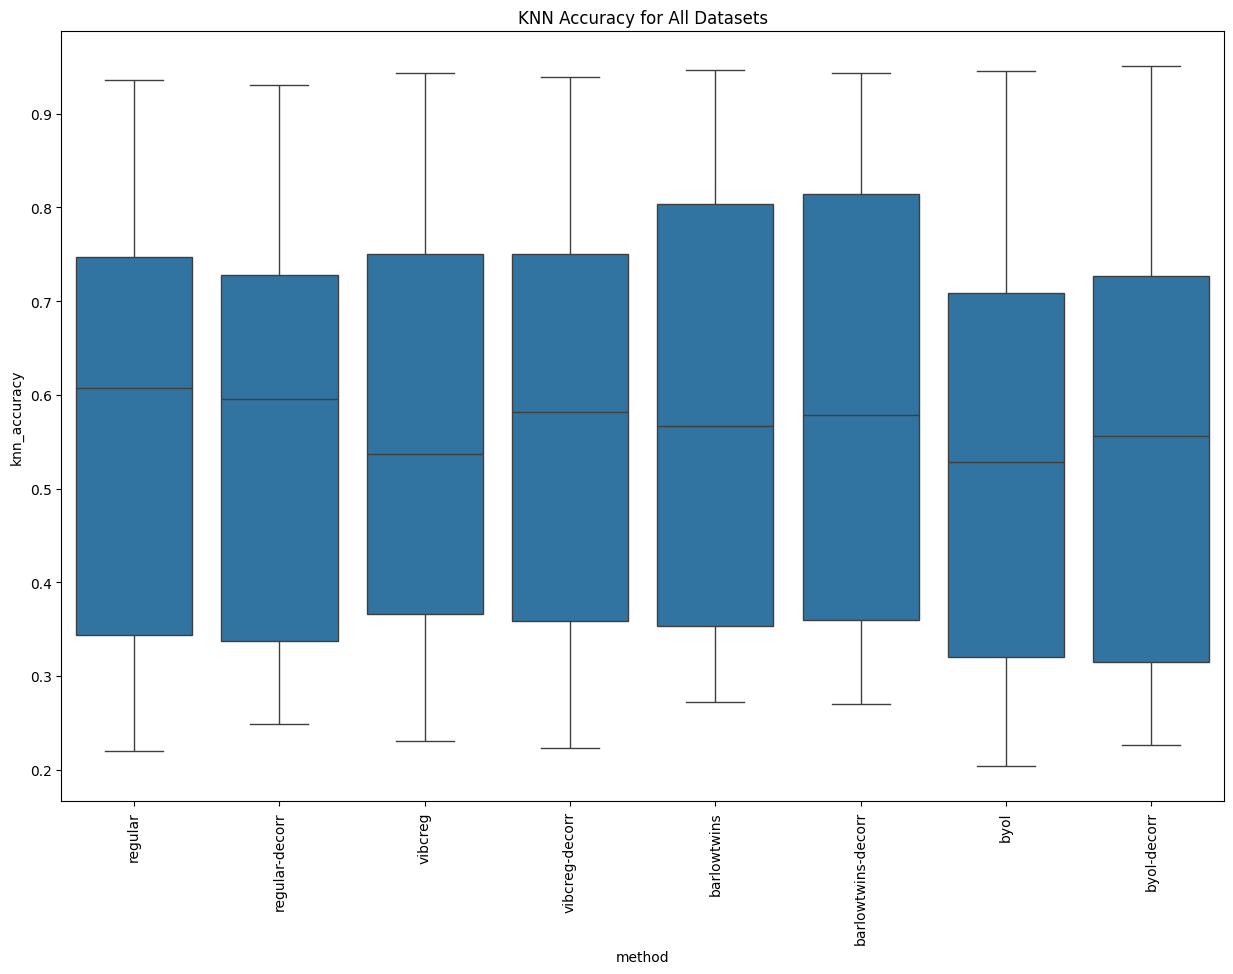

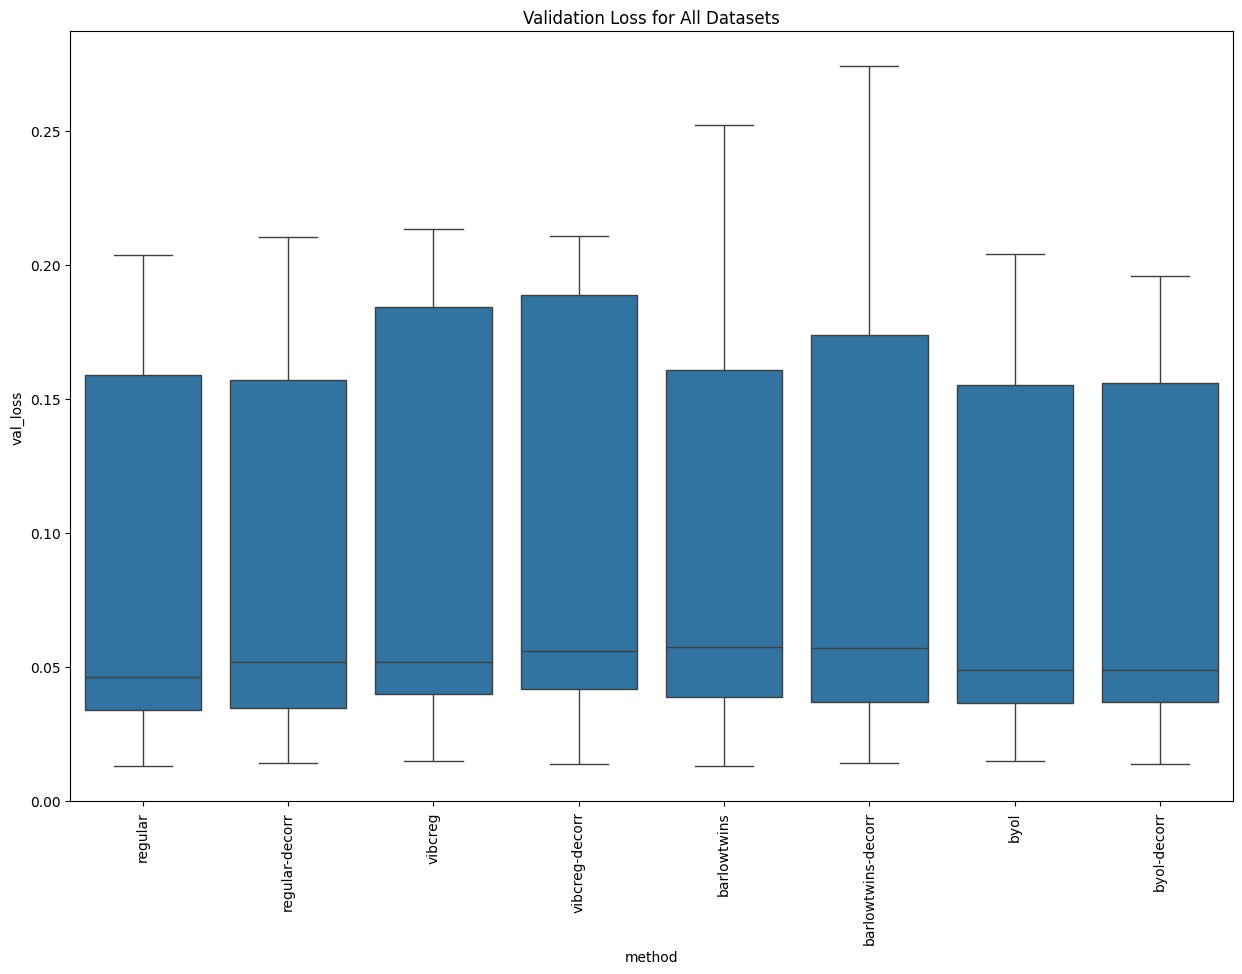

In [8]:
f, a = plt.subplots(len(datasets), 2, figsize=(10, 40))
for dataset in datasets:
    sns.boxplot(x="method", y="svm_accuracy", data=all_summaries_stage1[all_summaries_stage1["dataset"] == dataset], ax=a[datasets.index(dataset)][0])
    a[datasets.index(dataset)][0].set_title(f"SVM Accuracy for {dataset} - Stage 1")
    a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
    a[datasets.index(dataset)][0].set_ylim(0, 1)  # Set y-axis limits to 0-1
    sns.boxplot(x="method", y="knn_accuracy", data=all_summaries_stage1[all_summaries_stage1["dataset"] == dataset], ax=a[datasets.index(dataset)][1])
    a[datasets.index(dataset)][1].set_title(f"KNN Accuracy for {dataset} - Stage 1")
    a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels
    a[datasets.index(dataset)][1].set_ylim(0, 1)  # Set y-axis limits to 0-1
plt.subplots_adjust(hspace = 1)  # Add more vertical spacing between subplots
plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(x="method", y="svm_accuracy", data=all_summaries_stage1)
plt.title("SVM Accuracy for All Datasets")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(x="method", y="knn_accuracy", data=all_summaries_stage1)
plt.title("KNN Accuracy for All Datasets")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(x="method", y="val_loss", data=all_summaries_stage1)
plt.title("Validation Loss for All Datasets")
plt.xticks(rotation=90)
plt.show()

/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_74770/984774900.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_74770/984774900.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_74770/984774900.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation

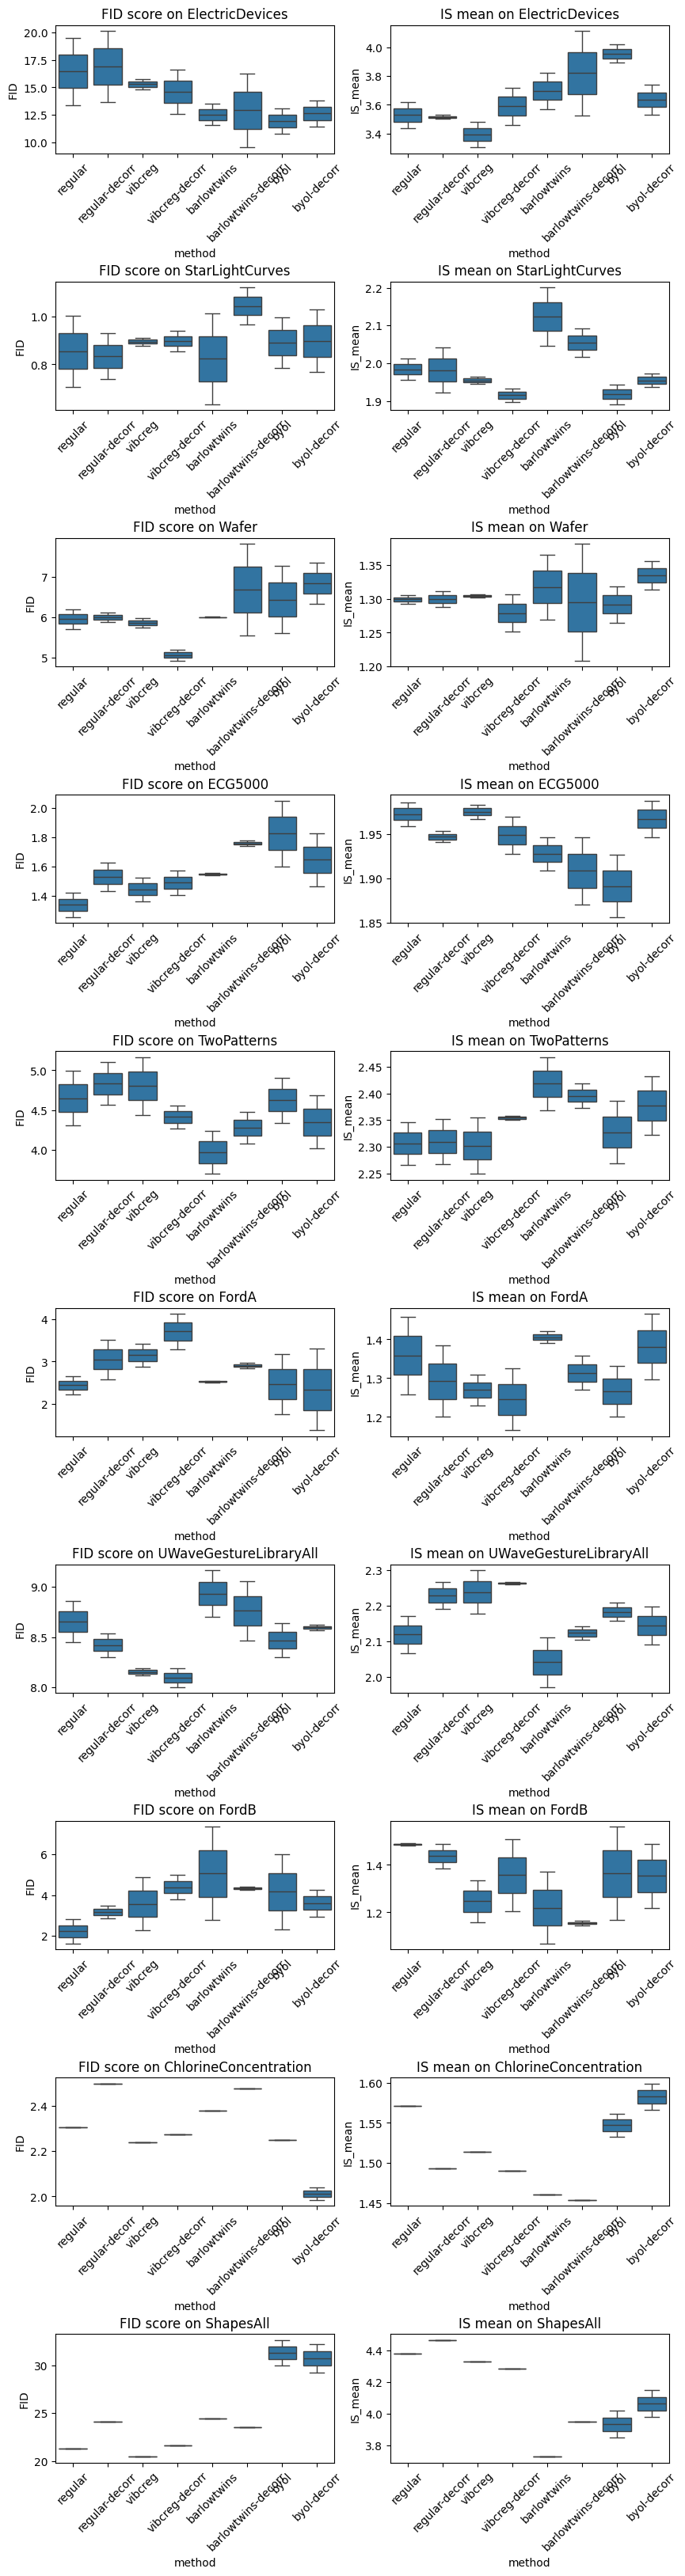

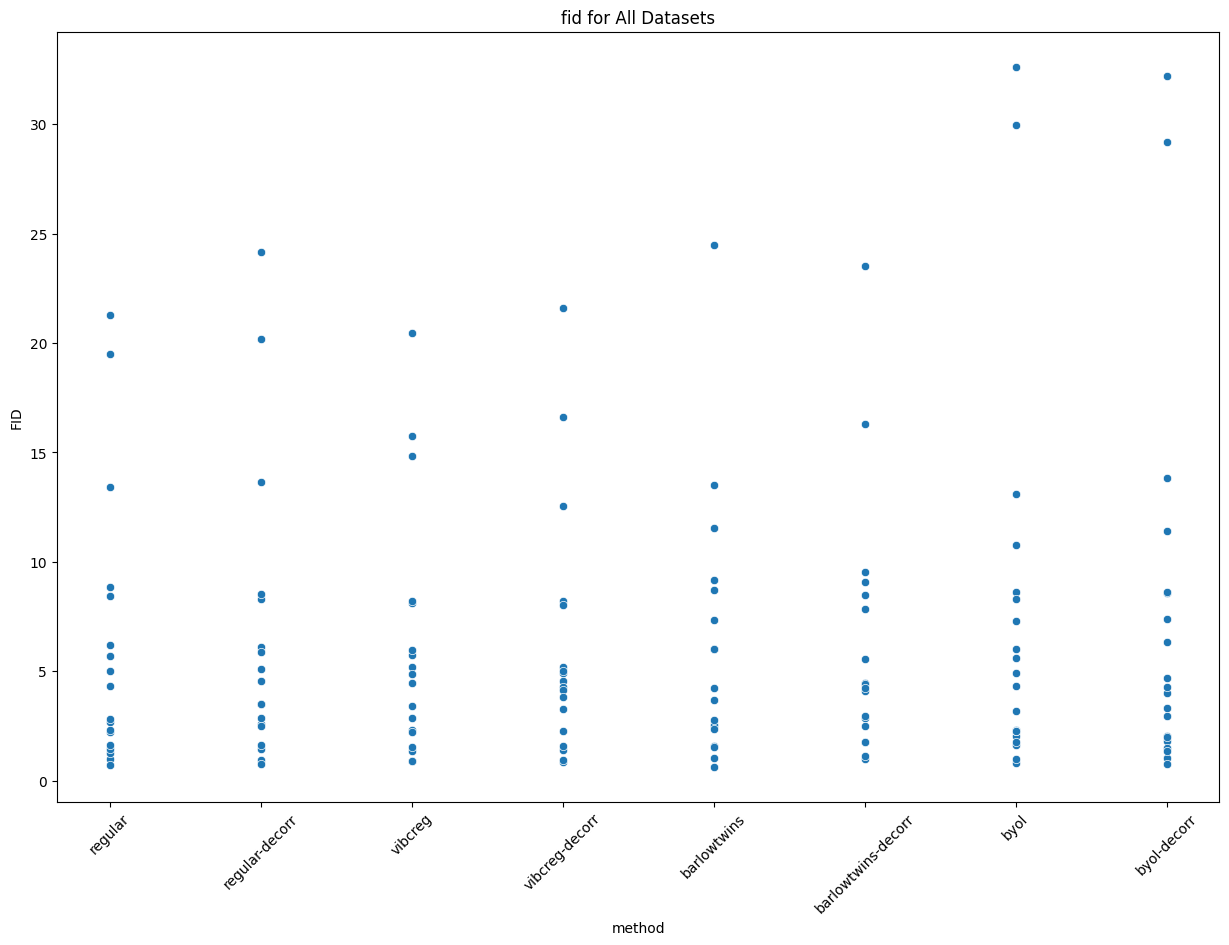

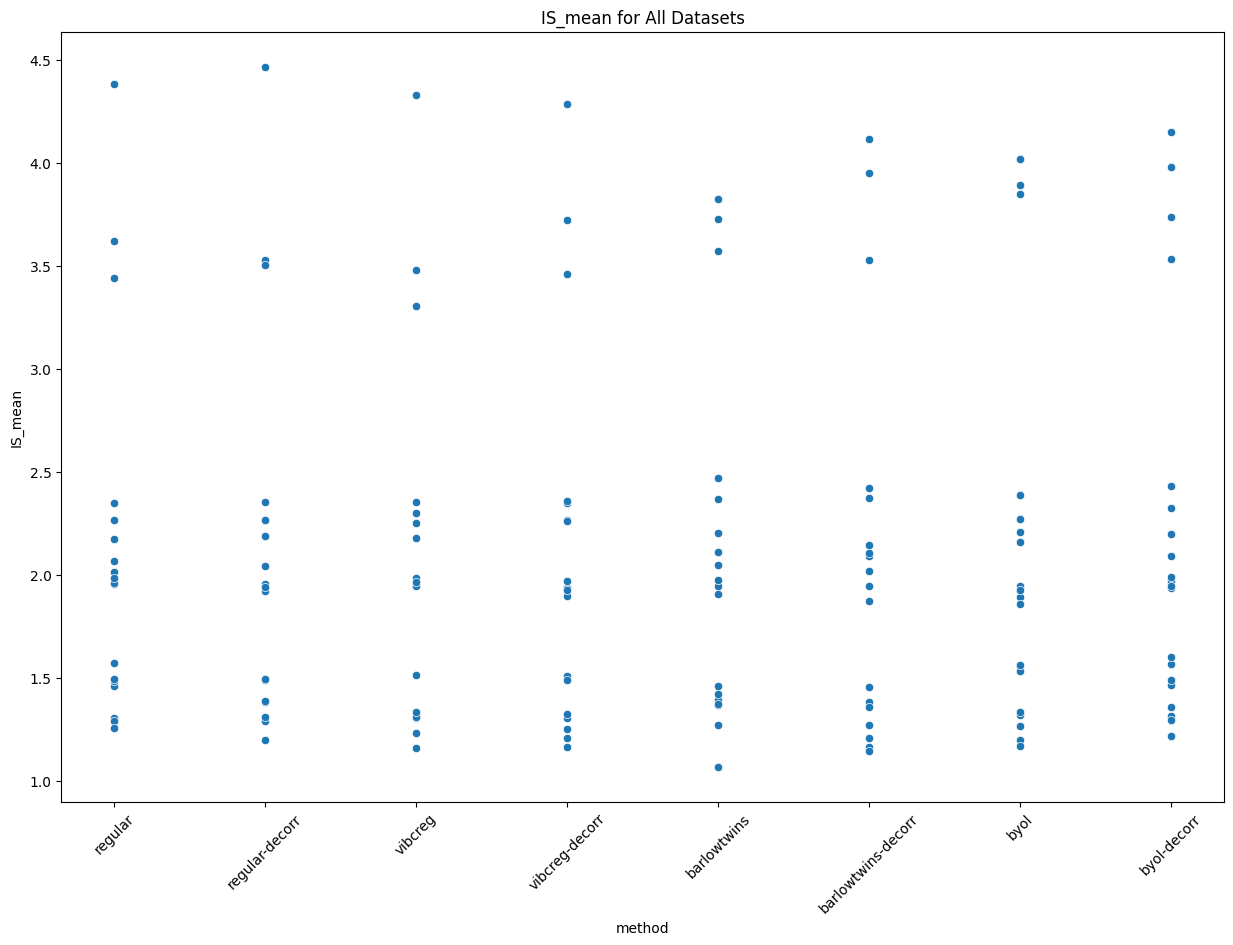

In [9]:
f, a = plt.subplots(len(datasets), 2, figsize=(10, 40))
for dataset in datasets:
    sns.boxplot(x="method", y="FID", data=all_summaries_stage2[all_summaries_stage2["dataset"] == dataset], ax=a[datasets.index(dataset)][0])
    a[datasets.index(dataset)][0].set_title(f"FID score on {dataset}")
    a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels

    sns.boxplot(x="method", y="IS_mean", data=all_summaries_stage2[all_summaries_stage2["dataset"] == dataset], ax=a[datasets.index(dataset)][1])
    a[datasets.index(dataset)][1].set_title(f"IS mean on {dataset}")
    a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels

plt.subplots_adjust(hspace = 1)  # Add more vertical spacing between subplots
plt.show()

plt.figure(figsize=(15, 10))
sns.scatterplot(x="method", y="FID", data=all_summaries_stage2)
plt.title("fid for All Datasets")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 10))
sns.scatterplot(x="method", y="IS_mean", data=all_summaries_stage2)
plt.title("IS_mean for All Datasets")
plt.xticks(rotation=45)
plt.show()